# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix




In [2]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [3]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [4]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


C:\Users\Andrea\AppData\Local\Temp\ipykernel_23644\3482823818.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i].loc[df[i]==j] = num
C:\Users\Andrea\AppData\Local\Temp\ipykernel_23644\3482823818.py:7: SettingWithCopyWarning: 
A value 

I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [5]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [6]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

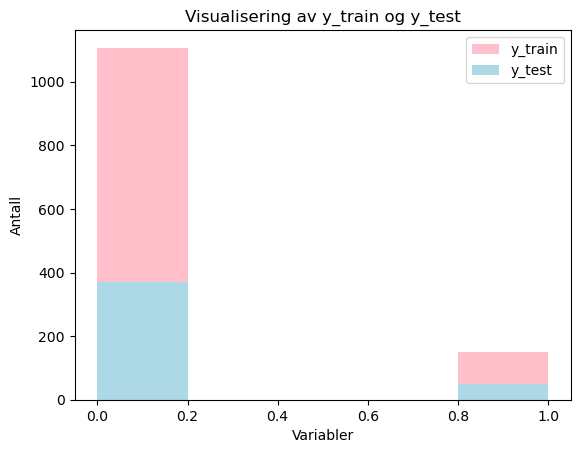

In [7]:
#visualiser y_train og y_test i et histogram

#Plot histogram med 5 bins og farge 
plt.hist(y_train, bins=5, label='y_train', color='pink')
plt.hist(y_test, bins=5, label='y_test', color='lightBlue')
plt.xlabel("Variabler")
plt.ylabel("Antall")
plt.title("Visualisering av y_train og y_test")
plt.legend()
plt.show()

**Svar:**

y_train og y_test (eller y_val) er binært fordelt med verdier 0 og 1. 
Som viser at det er et klassifiseringsproblem. 


#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


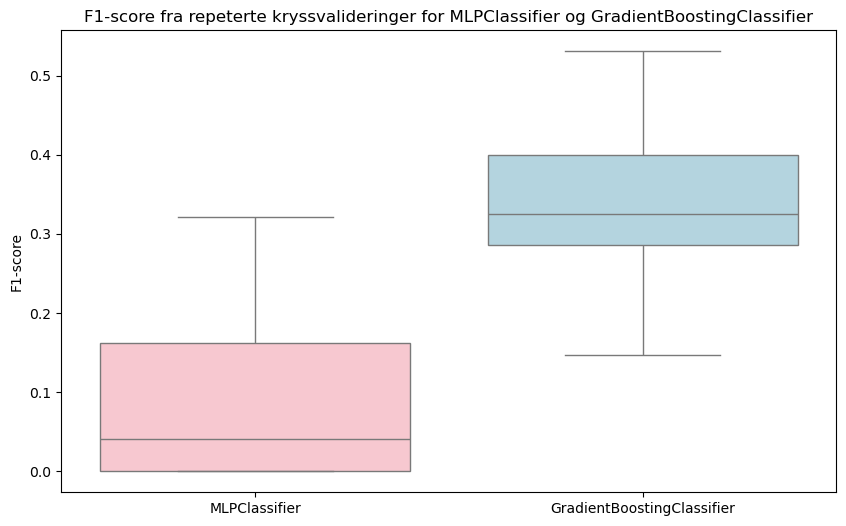

T-statistikk: -13.649890540328938
P-verdi: 2.1295546210415716e-24


In [8]:
#TODO: repeterte kryssvalideringer for to modeller

# Velg modellarkitekturer - MLPClassifier og GradientBoostingClassifier
model1 = MLPClassifier(random_state=0)
model2 = GradientBoostingClassifier(random_state=0)

# Vi bruker default hyperparametre her, men du kan også gjøre et hyperparametersøk om ønskelig


# Sett opp repeterte kryssvalideringer (10 repetisjoner med 5-folds kryssvalidering)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

# Definer scorere for F1-score og accuracy
f1_scorer = make_scorer(f1_score)
accuracy_scorer = make_scorer(accuracy_score)


# F1-scorer for modell 1 (MLPClassifier)
f1_scores_model1 = cross_val_score(model1, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)

# F1-scorer for modell 2 (GradientBoostingClassifier)
f1_scores_model2 = cross_val_score(model2, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)

# Accuracy-scorer for modell 1 (MLPClassifier)
accuracy_scores_model1 = cross_val_score(model1, X_train, y_train, scoring=accuracy_scorer, cv=cv, n_jobs=-1)

# Accuracy-scorer for modell 2 (GradientBoostingClassifier)
accuracy_scores_model2 = cross_val_score(model2, X_train, y_train, scoring=accuracy_scorer, cv=cv, n_jobs=-1)


# Opprett et boksplot for F1-skårene
plt.figure(figsize=(10, 6))
sns.boxplot(data=[f1_scores_model1, f1_scores_model2], palette=["pink", "lightblue"])
plt.xticks([0, 1], ['MLPClassifier', 'GradientBoostingClassifier'])
plt.ylabel('F1-score')
plt.title('F1-score fra repeterte kryssvalideringer for MLPClassifier og GradientBoostingClassifier')
plt.show()

# T-test for å sammenligne F1-skårene mellom de to modellene
t_stat, p_val = ttest_ind(f1_scores_model1, f1_scores_model2)

print("T-statistikk:", t_stat)
print("P-verdi:", p_val)


**Svar:**

 GradientBoostingClassifier presterer mye bedre og mer stabilt enn MLPClassifier. 
 
 Boxplottet viser at GradientBoostingClassifier har en høyere og jevnere F1-score, mens MLPClassifier varierer mer og har flere lave F1-scorer. 
 
 T-testen bekrefter forskjell mellom modellene, med en lav p-verdi som viser at GradientBoostingClassifier er bedre. 
 
 Basert på dette anbefales GradientBoostingClassifier som den beste modellen for denne oppgaven.

#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

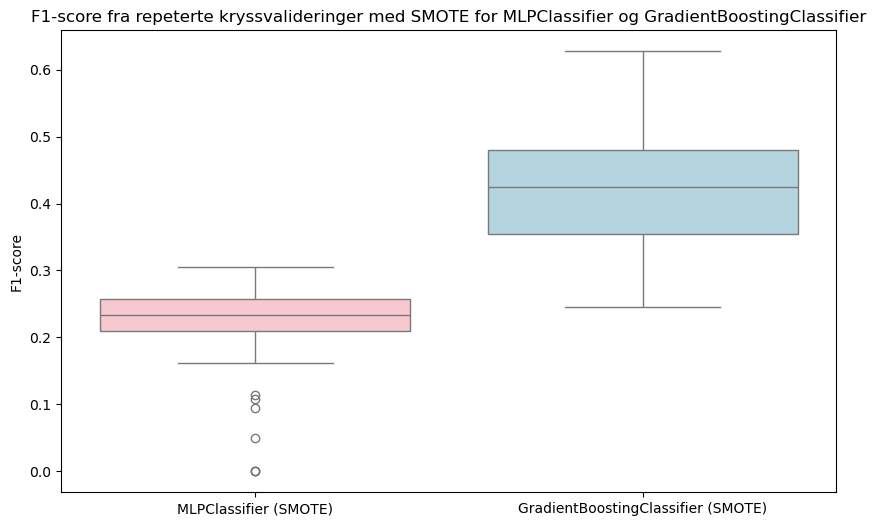

T-statistikk: -12.868403039646193
P-verdi: 8.865879984783452e-23


In [9]:
# repeterte kryssvalideringer for de samme to modellene som i oppgave 2.2, men denne gangen med SMOTE-oppsampling 
# from imblearn.over_sampling import SMOTE

# Definer modeller med SMOTE i en pipeline
model1 = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('classifier', MLPClassifier(random_state=0))
])

model2 = Pipeline([
    ('smote', SMOTE(random_state=0)),
    ('classifier', GradientBoostingClassifier(random_state=0))
])

# Repeterte kryssvalideringer (10 repetisjoner med 5-folds)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

# F1-scorer for modell 1 (MLPClassifier)
f1_scores_model1 = cross_val_score(model1, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)

# F1-scorer for modell 2 (GradientBoostingClassifier)
f1_scores_model2 = cross_val_score(model2, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)

# Accuracy-scorer for modell 1 (MLPClassifier)
accuracy_scores_model1 = cross_val_score(model1, X_train, y_train, scoring=accuracy_scorer, cv=cv, n_jobs=-1)

# Accuracy-scorer for modell 2 (GradientBoostingClassifier)
accuracy_scores_model2 = cross_val_score(model2, X_train, y_train, scoring=accuracy_scorer, cv=cv, n_jobs=-1)

# Oppretter boksplot for F1-scorer
plt.figure(figsize=(10, 6))
sns.boxplot(data=[f1_scores_model1, f1_scores_model2], palette=["pink", "lightblue"])
plt.xticks([0, 1], ['MLPClassifier (SMOTE)', 'GradientBoostingClassifier (SMOTE)'])
plt.ylabel('F1-score')
plt.title('F1-score fra repeterte kryssvalideringer med SMOTE for MLPClassifier og GradientBoostingClassifier')
plt.show()

# T-test for å sammenligne F1-skårene mellom de to modellene med SMOTE
t_stat, p_val = ttest_ind(f1_scores_model1, f1_scores_model2)

print("T-statistikk:", t_stat)
print("P-verdi:", p_val)


**Svar:**

Etter SMOTE viser GradientBoostingClassifier fortsatt bedre enn MLPClassifier. GradientBoostingClassifier har høyere og mer stabil F1-score, mens MLPClassifier har lavere score og flere avvikende verdier. 

T-testen gir en T-statistikk på -12.8 og en svært lav p-verdi 8.86e-23 som bekrefter at forskjellen er statistisk signifikant.

Sammenlignet med Oppgave 2.2, viser GradientBoostingClassifier forbedret ytelse med SMOTE og er fortsatt den beste modellen. MLPClassifier drar også nytte av SMOTE, men oppnår ikke samme nivå av ytelse eller stabilitet som GradientBoostingClassifier.

#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [10]:
# Tren den beste modellen fra 2.2 og 2.3 på alle treningsdataene og test på testdataene

# Tren GradientBoostingClassifier på hele treningssettet
best_model = GradientBoostingClassifier(random_state=0)
best_model.fit(X_train, y_train)

# Utfører prediksjon på testsettet
y_pred = best_model.predict(X_test)

# Lag en forvirringsmatrise
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Beregn ytelsesmålene
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Presisjon:", precision)
print("Sensitivitet (Recall):", recall)
print("Spesifisitet:", specificity)
print("F1-skår:", f1)


Accuracy: 0.8833333333333333
Presisjon: 0.5238095238095238
Sensitivitet (Recall): 0.22
Spesifisitet: 0.972972972972973
F1-skår: 0.30985915492957744


#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [11]:
#Gjør kjønnsbasert analyse på testdataene

# Del opp testsettet basert på kjønn (1 = menn, 0 = kvinner)
# Gjør kjønnsbasert analyse på testdataene
for gender, label in [(0, "Menn"), (1, "Kvinner")]:
    X_test_gender = X_test[X_test['Gender'] == gender]
    y_test_gender = y_test[X_test['Gender'] == gender]

    # Gjør prediksjoner og beregninger uten å sjekke om datasettet er tomt
    y_pred_gender = best_model.predict(X_test_gender)
    tn, fp, fn, tp = confusion_matrix(y_test_gender, y_pred_gender).ravel()
    accuracy = accuracy_score(y_test_gender, y_pred_gender)
    precision = precision_score(y_test_gender, y_pred_gender)
    sensitivity = recall_score(y_test_gender, y_pred_gender)
    specificity = tn / (tn + fp)

    print(f"{label}:" )
    print("Accuracy:", accuracy)
    print("Presisjon:", precision)
    print("Sensitivitet (Recall):", sensitivity)
    print("Spesifisitet:", specificity)
    print()


Menn:
Accuracy: 0.8656126482213439
Presisjon: 0.5714285714285714
Sensitivitet (Recall): 0.2222222222222222
Spesifisitet: 0.9723502304147466

Kvinner:
Accuracy: 0.9101796407185628
Presisjon: 0.42857142857142855
Sensitivitet (Recall): 0.21428571428571427
Spesifisitet: 0.9738562091503268



**Svar:**

* Er modellen like god for begge kjønn?

    Modellen presterer litt ulikt for menn og kvinner. 
    
    Accuracy er høyere for kvinner (91.0%) enn for menn (86.6%), men menn har bedre presisjon (57.1% mot 42.9%). 
    
    Dette betyr at modellen er mer nøyaktig i sine positive prediksjoner for menn, men gjør generelt flere riktige prediksjoner for kvinner totalt sett. 
    
    Sensitiviteten (recall) er lav for begge kjønn (21.4% for kvinner og 22.2% for menn), noe som betyr at modellen sliter med å fange opp positive tilfeller. 
    
    Spesifisiteten er lik for begge kjønn, med rundt 97%, og viser at modellen er god på å identifisere negative tilfeller. 
    
    Totalt sett er modellen ikke like god for begge kjønn, men forskjellene er små.
    

* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

    Årsak: 
    Ubalanse i antall menn og kvinner i datasettet.
    
    Tiltak:
    1. Utføre hyperparametersøk
    2. Balansere dataene med SMOTE før oppdeling. 
    3. Lav sensitivitet kan skyldes skjev fordeling mellom positive og negative klasser.


Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [13]:
!pip freeze > requirements.txt